# Uber Supply-Demand Gap Analysis

This project analyzes Uber request data to identify patterns in demand, supply gaps, and service performance using visualizations.

**Tools:** Python, Pandas, SQL, Seaborn, Matplotlib

##  Imports & Data Load

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset
df = pd.read_csv(r"C:\Users\sidde\Downloads\Uber Request Data.csv")
# Parse timestamps
df['Request timestamp'] = pd.to_datetime(df['Request timestamp'], errors='coerce')
df['Drop timestamp'] = pd.to_datetime(df['Drop timestamp'], errors='coerce')
df = df.dropna(subset=['Request timestamp'])

# Extract hour
df['Request hour'] = df['Request timestamp'].dt.hour

# Map to time slots
def get_time_slot(hour):
    if pd.isna(hour): return 'Unknown'
    elif 0 <= hour < 4: return 'Late Night'
    elif 4 <= hour < 8: return 'Early Morning'
    elif 8 <= hour < 12: return 'Morning'
    elif 12 <= hour < 16: return 'Afternoon'
    elif 16 <= hour < 20: return 'Evening'
    else: return 'Night'

df['Time slot'] = df['Request hour'].apply(get_time_slot)

# Clean categories
df['Status'] = df['Status'].astype(str).str.strip().str.title()
df['Pickup point'] = df['Pickup point'].astype(str).str.strip().str.title()
df = df.dropna(subset=['Status', 'Pickup point'])

df.head()
#SQL integration
conn = sqlite3.connect(":memory:")
df.to_sql("uber_data", conn, index=False, if_exists="replace")

# Preview table
pd.read_sql("SELECT * FROM uber_data LIMIT 5", conn)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request hour,Time slot
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,11,Morning
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,17,Evening
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,9,Morning
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,21,Night
4,267,City,2.0,Trip Completed,2016-11-07 06:46:00,2016-11-07 07:25:00,6,Early Morning


##  Data Visualization

### Chart 1: Trip Completions by Time Slot

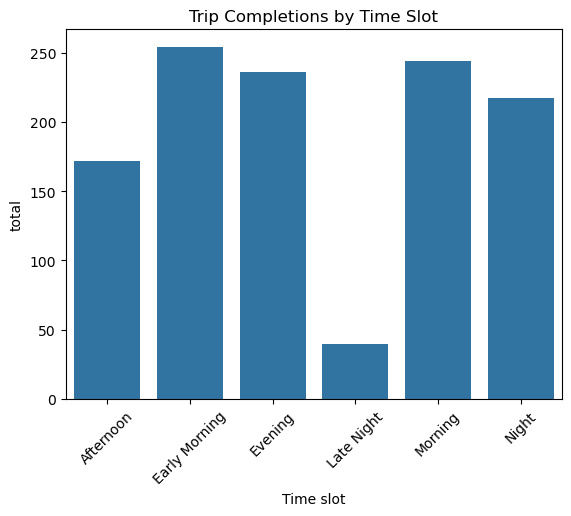

In [ ]:
# Completed Trips by Time Slot (via SQL)
query = """
SELECT [Time slot], COUNT(*) AS total
FROM uber_data
WHERE Status = 'Trip Completed'
GROUP BY [Time slot]
"""
results = pd.read_sql_query(query, conn)
sns.barplot(data=results, x='Time slot', y='total')
plt.title("Trip Completions by Time Slot")
plt.xticks(rotation=45)
plt.show()

### Chart 2: Total Requests by Time Slot

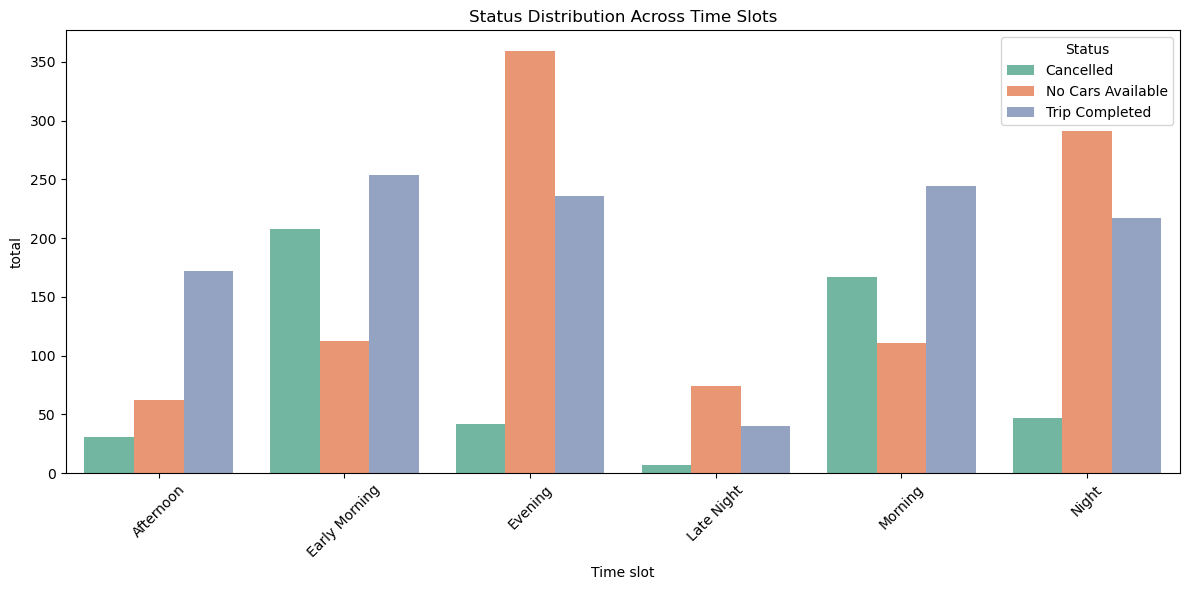

In [ ]:
query = """
SELECT [Time slot], Status, COUNT(*) AS total
FROM uber_data
GROUP BY [Time slot], Status
"""
df2 = pd.read_sql(query, conn)

plt.figure(figsize=(12,6))
sns.barplot(data=df2, x='Time slot', y='total', hue='Status', palette='Set2')
plt.title('Status Distribution Across Time Slots')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Chart 3: Status by Pickup Point 

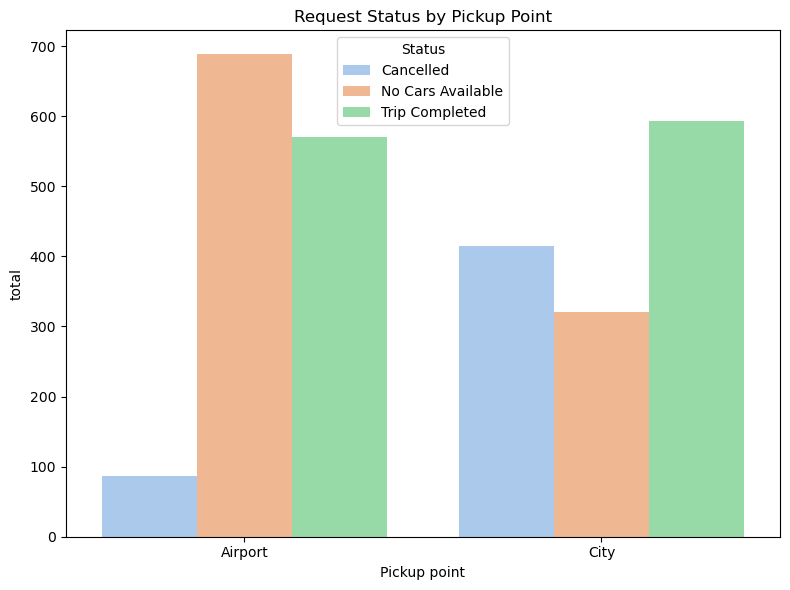

In [ ]:
query = """
SELECT [Pickup point], Status, COUNT(*) AS total
FROM uber_data
GROUP BY [Pickup point], Status
"""
df3 = pd.read_sql(query, conn)

plt.figure(figsize=(8,6))
sns.barplot(data=df3, x='Pickup point', y='total', hue='Status', palette='pastel')
plt.title('Request Status by Pickup Point')
plt.tight_layout()
plt.show()

### Chart 4:  Heatmap of Completed Trips

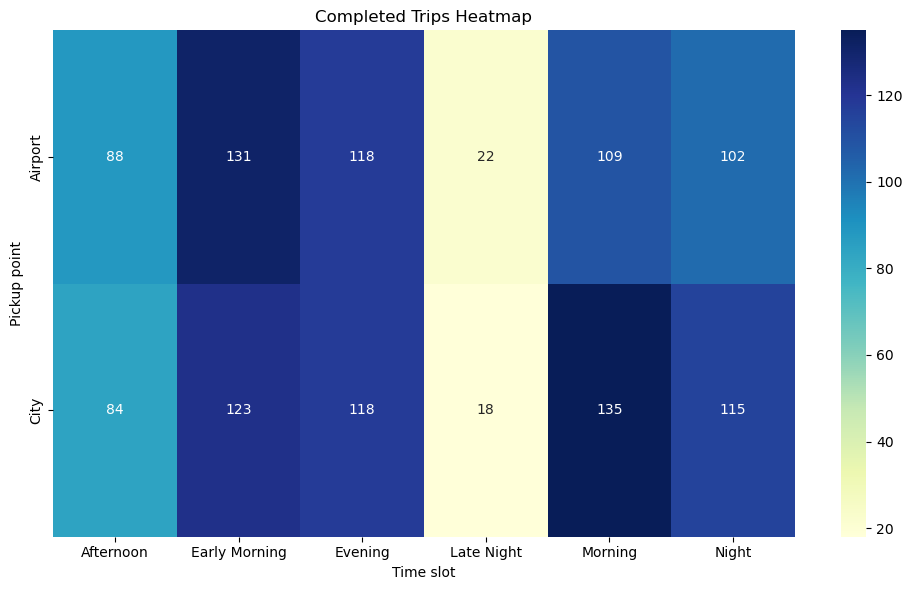

In [ ]:
query = """
SELECT [Pickup point], [Time slot], COUNT(*) AS total
FROM uber_data
WHERE Status = 'Trip Completed'
GROUP BY [Pickup point], [Time slot]
"""
df4 = pd.read_sql(query, conn)

pivot = df4.pivot(index='Pickup point', columns='Time slot', values='total').fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Completed Trips Heatmap')
plt.tight_layout()
plt.show()

### Chart 5: Hourly Requests

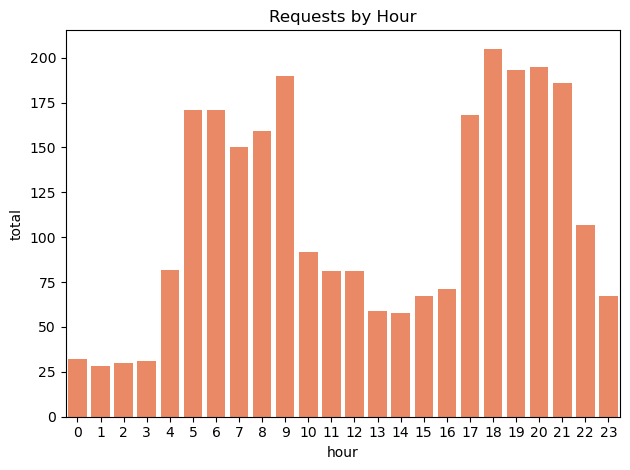

In [ ]:
query = """
SELECT [Request hour] AS hour, COUNT(*) AS total
FROM uber_data
GROUP BY hour
ORDER BY hour
"""
df5 = pd.read_sql(query, conn)

sns.barplot(data=df5, x='hour', y='total', color='coral')
plt.title('Requests by Hour')
plt.tight_layout()
plt.show()


### Chart 6: Ride Status Pie

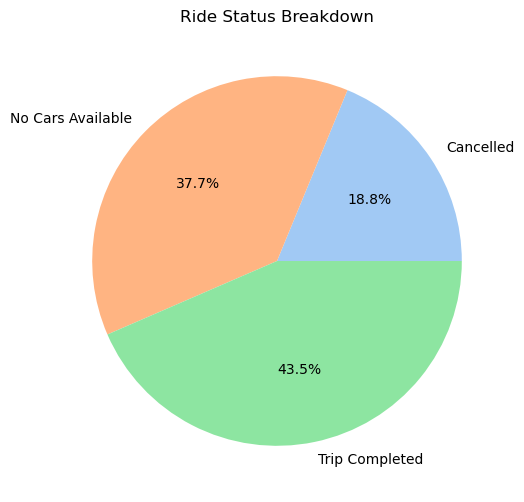

In [ ]:
query = """
SELECT Status, COUNT(*) AS total
FROM uber_data
GROUP BY Status
"""
df6 = pd.read_sql(query, conn)

plt.figure(figsize=(6,6))
plt.pie(df6['total'], labels=df6['Status'], autopct='%1.1f%%',
        colors=sns.color_palette('pastel'))
plt.title('Ride Status Breakdown')
plt.show()


### Chart 7: Cancellations by Time Slot

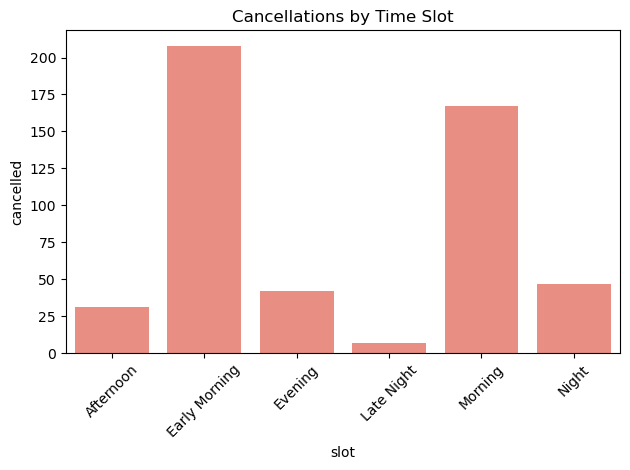

In [ ]:
query = """
SELECT [Time slot] AS slot, COUNT(*) AS cancelled
FROM uber_data
WHERE Status = 'Cancelled'
GROUP BY [Time slot]
"""
df7 = pd.read_sql(query, conn)

sns.barplot(data=df7, x='slot', y='cancelled', color='salmon')
plt.title('Cancellations by Time Slot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Chart 8: No Cars by Time Slot

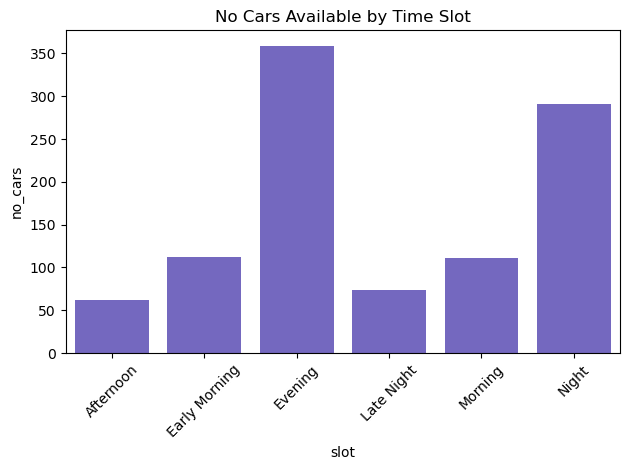

In [ ]:
query = """
SELECT [Time slot] AS slot, COUNT(*) AS no_cars
FROM uber_data
WHERE Status = 'No Cars Available'
GROUP BY [Time slot]
"""
df8 = pd.read_sql(query, conn)

sns.barplot(data=df8, x='slot', y='no_cars', color='slateblue')
plt.title('No Cars Available by Time Slot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Chart 9: Completion Rate by Time Slot

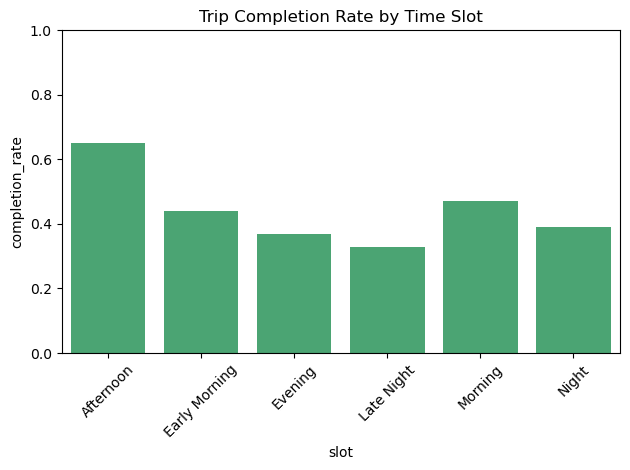

In [ ]:
query = """
SELECT [Time slot] AS slot,
    ROUND(SUM(CASE WHEN Status = 'Trip Completed' THEN 1 ELSE 0 END)*1.0 / COUNT(*), 2) AS completion_rate
FROM uber_data
GROUP BY [Time slot]
"""
df9 = pd.read_sql(query, conn)

sns.barplot(data=df9, x='slot', y='completion_rate', color='mediumseagreen')
plt.title('Trip Completion Rate by Time Slot')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###  Insights & Solutions

### Insights
- Supply-demand gap is highest during Late Night and Early Morning
- Most cancellations happen early morning from Airport

### Solutions
- Night shift incentives for drivers
- Rush hour bonuses during 5 - 8 AM
- Better car distribution algorithms

###  Conclusion
This analysis identifies key inefficiencies in Uber’s supply chain.  
Using **Python, SQL, and Excel**, we created a clear picture of time-based demand gaps, cancellations, and no-car availability trends.  
These insights can directly support business decisions on driver allocation and incentives.